In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.morphology import binary_dilation, binary_erosion
from random import choice

import py4DSTEM

In [54]:
fp = "/home/ben/Data/20190128_ClassificationData/EASY_binDiffraction4.h5"
#fp = "/Users/Ben/Desktop/EASY_binDiffraction4_no_datacube.h5"
browser = py4DSTEM.file.readwrite.FileBrowser(fp)
ave_im = browser.get_dataobject('average_image').data2D
deconvolution = browser.get_dataobject('deconvolution').data2D
bragg_peaks_by_scan_position_pla = browser.get_dataobject('braggpeak_sets_by_scan_position_pla')
initial_classification = browser.get_dataobject('initial_classification').data2D
#braggpeaks = browser.get_dataobject('Bragg_peaks')

browser.close()

In [55]:
Q_Nx,Q_Ny = deconvolution.shape
R_Nx,R_Ny = ave_im.shape

In [56]:
braggpeak_sets_by_scan_position = [[set() for i in range(R_Ny)] for j in range(R_Nx)]

for Rx in range(R_Nx):
    for Ry in range(R_Ny):
            indices = bragg_peaks_by_scan_position_pla.get_pointlist(Rx,Ry).data['i']
            braggpeak_sets_by_scan_position[Rx][Ry] = set(indices)

In [66]:
N=0
for Rx in range(R_Nx):
    for Ry in range(R_Ny):
        try:
            N_max = max(braggpeak_sets_by_scan_position[Rx][Ry])
            if N < N_max:
                N = N_max
        except ValueError:
            pass
N+=1

# Classification and ClassLabel objects

In [67]:
class Classification(object):
    """
    A classification of a 4D STEM dataset.
    
    A classification object consists of two states: the current state and the next state.
    For each state, there is a:
        classification      (shape (Rx,Ry) array of ints) the class labels k at each scan position
        classes             (len N_classes list of ClassLabel objects) the classes
        cost                (float) measure to minimize
    A classification has the following methods:
        new_class(rx,ry)           generate a possible next state by seeding a new class from scan position rx,ry + NNs
        grow_class(i)              generate a possible next state by expanding class i
        merge_classes(i,j)         generate a possible next state by merging classes i and j
        get_new_state()            gets a possible next state with one of the previous three methods, and updates next_state
        accept_next_state()        current state := next_state; next_state := new_state
        reject_next_state()        current state := current_state; next_state := new_state
        get_current_cost()         get the cost of the current state
        get_next_cost()            get the cost of the next state
        get_class_mask(i)          returns an (Rx,Ry) ndarray of bools specifying class i scan positions
    The classification object may be initialized with a 2D array of ints, giving the class values k; if this is
    provided, the classification object will initialize a set of classlabel objects accordingly.
    """
    def __init__(self,R_Nx,R_Ny,N,V,thresh,braggpeak_sets_by_scan_position,alpha,
                 unclassified_cost,grow_merge_new_ratio=[1,20,20],N_rand_positions=20,classification=None):
        """Accepts:
                R_Nx,R_Ny                      (ints) scan shape
                N                              (int) number of indexed Bragg peaks
                V,thresh                       (floats) cost function and ClassLabel parameters
                bragg_peaks_by_scan_position   (list of lists of sets) the set of Bragg peaks by scan position
                alpha                          (float) the cost of having additional classes
                unclassified_cost              (float) the cost of having an unclassified pixel
                grow_merge_new_ratio           (length-3 list of ints) when time-evolving, ratio of grow/merge/new steps attempted
                classification                 (shape (R_Nx,R_Ny) array of ints) an initial classification
        """
        self.R_Nx,self.R_Ny,self.N = R_Nx,R_Ny,N
        self.classification_current = -np.ones((self.R_Nx,self.R_Ny),dtype=int)   # -1 refers to a pixel which is
        self.classification_next = -np.ones((self.R_Nx,self.R_Ny),dtype=int)      # as-yet unassigned to a class
        self.classes_current = []
        self.classes_next = []
        self.N_classes_current = 0
        self.N_classes_next = 0
        self.class_indices_current = []
        self.class_indices_next = []
        self.class_index_current = 0
        self.class_index_next = 0
        self.cost_current = 0
        self.cost_next = 0
        
        self.delta_forward = -2*np.ones((self.R_Nx,self.R_Ny),dtype=int)     # -2 refers to unchanged pixels
        self.delta_backward = -2*np.ones((self.R_Nx,self.R_Ny),dtype=int)    # 0 and -1 are already in use!
        self.t=0
        self.N_rand_positions = N_rand_positions
        self.get_grow_merge_new_steps(grow_merge_new_ratio)            # Defines self.steps, specifying when
                                                                             # to attempt which type of new state
        self.alpha = alpha
        self.V = V
        self.thresh = thresh
        self.braggpeak_sets_by_scan_position = braggpeak_sets_by_scan_position
        self.unclassified_cost = unclassified_cost
        
        if classification is not None:
            self.get_current_state_from_classification(classification)
            self.get_next_state_from_current_state()
    
    def get_new_state(self):
        """Updates to the next state.
        
           Assumes next_state begins in the same state as current_state; this is ensured as long as
           self.accept_next_state() or self.reject_next_state() has been run since the last self. get_new_state() call.
           
           Generates two (R_Nx,R_Ny) arrays of ints: delta_forward and delta_backward. 
           These store changes so that rejected changes in next state can be reverted if needed.
           In both, -2 represents no change, a number represents the class to change this pixel to.
  
           delta_forward and delta_backward are generated by calling new_class, grow_class, or merge_class.
           Which is called is controlled by the class parameter 
        """
                
        COST = 0
        
        # Choose a new step type 
        step_type = self.steps[self.t%(len(self.steps))]
        self.t += 1
        if step_type==1:
            rx,ry = self.select_new_seed_positions()
            self.new_class(rx,ry)
        elif step_type==2:
            i = self.select_a_class()
            self.grow_class(i)
        elif step_type==3:
            i,j = self.select_class_pair()
            self.merge_classes(i,j)
        else:
            raise Exception("Error: step_type must be 1,2, or 3, not {}".format(step_type))
        
        # Set next state, and its cost, from the lists of new, removed, and changed classlabels
        self.classification_next = np.where(self.delta_forward!=-2,self.delta_forward,self.classification_next)
        for new_class_index in self.new_class_indices:
            mask = self.delta_forward==new_class_index
            new_class = ClassLabel(index=new_class_index,mask=mask,N=self.N,V=self.V,thresh=self.thresh)
            self.classes_next.append(new_class)
            self.class_indices_next.append(new_class_index)
            self.class_index_next += 1
            self.N_classes_next += 1
            # TODO: why does this assertion fail?
            #assert(np.all(self.classification_next[mask] == new_class_index))
            COST += new_class.my_cost
        for removed_class_index in self.removed_class_indices:
            removed_class = self.get_class_next(removed_class_index)
            self.classes_next.remove(removed_class)
            self.class_indices_next.remove(removed_class_index)
            self.N_classes_next -= 1
            COST -= removed_class.my_cost
            del removed_class
        for grown_class_index in self.grown_class_indices:
            if grown_class_index!=-1:
                grown_class = self.get_class_next(grown_class_index)
                mask = self.delta_forward==grown_class_index
                rx,ry = np.nonzero(mask)
                cost_temp = grown_class.my_cost
                grown_class.add_data_by_scan_position(rx,ry)
                COST += (grown_class.my_cost - cost_temp)
            else:
                mask = self.delta_forward==grown_class_index
                COST += self.unclassified_cost * np.sum(mask)
        for eroded_class_index in self.eroded_class_indices:
            eroded_class = self.get_class_next(eroded_class_index)
            mask = self.delta_backward==eroded_class_index
            rx,ry = np.nonzero(mask)
            if eroded_class_index!=-1:
                cost_temp = eroded_class.my_cost
                eroded_class.remove_data_by_scan_position(rx,ry)
                COST += (eroded_class.my_cost - cost_temp)
            else:
                COST = self.unclassified_cost * np.sum(mask)

        COST += self.alpha * (self.N_classes_next-self.N_classes_current)
        COST += self.unclassified_cost * (np.sum(self.classification_next==-1)-np.sum(self.classification_next==-1))

        print('N_classes = {}'.format(self.N_classes_next))
        print(COST)
        
        if COST < 0:
            self.accept_next_state()
        else:
            self.reject_next_state()

        return COST


    def new_class(self,rx,ry):
        """Generates a possible next state by seeding a new class from the scan position rx,ry and its 8 NNs.
           Returns:
               delta_forward          the proposed changes
               delta_backward         the current state of the changed pixels
               new_class_indices      a list of ints containing indices for any new classes
               removed_class_indices  a list of ints containing indices of any removed classes
               grown_class_indices    a list of ints containing indices of classes which grew
               eroded_class_indices   a list of ints containing indices of classes which eroded
        """
        # Define objects to return
        self.delta_forward = -2*np.ones((self.R_Nx,self.R_Ny))
        self.delta_backward = -2*np.ones((self.R_Nx,self.R_Ny))
        self.new_class_indices = []
        self.removed_class_indices = []
        self.eroded_class_indices = []
        self.grown_class_indices = []
        # Get set of all NN pixels, handling edges
        rx_min = rx - 1*(rx>0)
        ry_min = ry - 1*(ry>0)
        rx_max = rx + 1 + 1*(rx<(self.R_Nx-1))
        ry_max = ry + 1 + 1*(ry<(self.R_Ny-1))
        rxx,ryy = np.meshgrid(np.arange(rx_min,rx_max),np.arange(ry_min,ry_max))
        rx,ry = rxx.ravel(),ryy.ravel()
        # Add the changes to delta_forward and delta_backward
        new_class_index = self.class_index_next   # Don't increment self.class_index_next; we haven't actually added it yet!
        eroded_classes_temp = []
        for j in range(len(rx)):
            i = self.classification_next[rx[j],ry[j]]
            self.delta_backward[rx[j],ry[j]] = i
            self.delta_forward[rx[j],ry[j]] = new_class_index
            eroded_classes_temp.append(i)
        # Get any new / erode / remove classes
        self.new_class_indices.append(new_class_index)
        eroded_classes_temp = set(eroded_classes_temp)
        for eroded_class_index in eroded_classes_temp:
            if eroded_class_index not in self.classification_next[self.delta_forward==-2]:
                self.removed_class_indices.append(eroded_class_index)
            else:
                self.eroded_class_indices.append(eroded_class_index)
        return
        
    def grow_class(self,i):
        """Generates a possible next state by growing class i into adjacent cells which will reduce the total cost.
           Returns:
               delta_forward          the proposed changes
               delta_backward         the current state of the changed pixels
               new_class_indices      a list of ints containing indices for any new classes
               removed_class_indices  a list of ints containing indices of any removed classes
               grown_class_indices    a list of ints containing indices of classes which grew
               eroded_class_indices   a list of ints containing indices of classes which eroded
        """
        # Define objects to return
        self.delta_forward = -2*np.ones((self.R_Nx,self.R_Ny))
        self.delta_backward = -2*np.ones((self.R_Nx,self.R_Ny))
        self.new_class_indices = []
        self.removed_class_indices = []
        self.grown_class_indices = []
        self.eroded_class_indices = []
        # Get class, possible growth pixels
        growing_class = self.get_class_next(i)
        growth_mask = np.logical_xor(growing_class.mask,binary_dilation(growing_class.mask))
        rx,ry = np.nonzero(growth_mask)
        # Determine if each pixel will raise or lower cost, and construct delta_forward/delta_backward
        self.grown_class_indices = [i]
        for j in range(len(rx)):
            s = self.braggpeak_sets_by_scan_position[rx[j]][ry[j]] # The BPs at the cell in question
            i_eroded = self.classification_next[rx[j],ry[j]]       # The index of the class being eroded
            if i_eroded != -1:
                #print(i_eroded)
                #for i in range(len(self.classes_next)):
                #    print(self.classes_next[i].index)
                eroded_class = self.get_class_next(i_eroded)
                cost_eroded = eroded_class.cost(s)                 # The cost of this cell in the eroded class
            else:
                cost_eroded = unclassified_cost                    # Cost for losing an unassigned pixel
            cost_growing = growing_class.cost(s)                   # The cost of this cell in the growing class
            
            if cost_growing < cost_eroded:
                self.delta_forward[rx[j],ry[j]] = i
                self.delta_backward[rx[j],[ry[j]]] = i_eroded
                self.eroded_class_indices.append(i_eroded)
        # Get any changed or removed classes
        self.eroded_class_indices = set(self.eroded_class_indices)
        for eroded_class_index in self.eroded_class_indices:
            if eroded_class_index not in self.classification_next[self.delta_forward==-2]:
                self.eroded_class_indices.remove(eroded_class_index)
                self.removed_class_indices.append(eroded_class_index)
        return   
        
    def merge_classes(self,i,j):
        """Generates a possible next state by merging class i into class j.
           Returns:
               delta_forward          the proposed changes
               delta_backward         the current state of the changed pixels
               new_class_indices      a list of ints containing indices for any new classes
               removed_class_indices  a list of ints containing indices of any removed classes
               grown_class_indices    a list of ints containing indices of classes which grew
               eroded_class_indices   a list of ints containing indices of classes which eroded
        """
        # Define objects to return
        self.delta_forward = -2*np.ones((self.R_Nx,self.R_Ny))
        self.delta_backward = -2*np.ones((self.R_Nx,self.R_Ny))
        self.new_class_indices = []
        self.removed_class_indices = []
        self.grown_class_indices = []
        self.eroded_class_indices = []
        # Get classes
        growing_class = self.get_class_next(j)
        eroding_class = self.get_class_next(i)
        # Populate delta_forward and delta_backward
        self.delta_forward[self.classification_current==i] = j
        self.delta_backward[self.classification_current==i] = i
        self.removed_class_indices.append(i)
        self.grown_class_indices.append(j)
        return

    def accept_next_state(self):
        """Sets current_state := next_state; next_state := next_state.
        """
        classification_temp = np.copy(self.classification_next)
        self.classification_current = self.classification_next
        self.classification_next = classification_temp

        N_classes_temp = np.copy(self.N_classes_next)
        self.N_classes_current = self.N_classes_next
        self.N_classes_next = N_classes_temp
        
        class_indices_temp = [np.copy(index) for index in self.class_indices_current]
        self.class_indices_current = self.class_indices_next
        self.class_indices_next = class_indices_temp
        
        class_index_temp = np.copy(self.class_index_next)
        self.class_index_current = self.class_index_next
        self.class_index_next = class_index_temp
        
        # Time evolving the classes
        # Update the current next state
        self.classification_current = np.where(self.delta_forward!=-2,self.delta_forward,self.classification_current)     
        for new_class_index in self.new_class_indices:
            mask = self.delta_forward==new_class_index
            new_class = ClassLabel(index=new_class_index,mask=mask,N=self.N,V=self.V,thresh=self.thresh)
            self.N_classes_current += 1
            self.class_indices_current.append(self.class_index_next)
            self.class_index_current += 1
            assert(np.all(self.classification_current[mask] == new_class_index))
        for removed_class_index in self.removed_class_indices:
            removed_class = self.get_class_current(removed_class_index)
            self.classes_current.remove(removed_class)
            self.class_indices_current.remove(removed_class_index)
            self.N_classes_current -= 1
            del removed_class
        for grown_class_index in self.grown_class_indices:
            grown_class = self.get_class_current(grown_class_index)
            mask = self.delta_forward==grown_class_index
            rx,ry = np.nonzero(mask)
            grown_class.add_data_by_scan_position(rx,ry)
        for eroded_class_index in self.eroded_class_indices:
            eroded_class = self.get_class_current(eroded_class_index)
            mask = self.delta_backward==eroded_class_index
            rx,ry = np.nonzero(mask)
            eroded_class.remove_data_by_scan_position(rx,ry)
    
    def reject_next_state(self):
        """Leaves current state unchanged. Reverts next_state := current_state.
        """
        classification_next = np.copy(self.classification_current)
        self.N_classes_next = np.copy(self.N_classes_current)
        #self.class_indices_next = [np.copy(index) for index in self.class_indices_current]
        self.class_index_next = np.copy(self.class_index_current)
        
        # Time evolving the classes
        # Reset the next state to the current state
        self.classification_next = np.where(self.delta_backward!=-2,self.delta_backward,self.classification_next)      
        for removed_class_index in self.new_class_indices:          # Remove the new classes...
            removed_class = self.get_class_next(removed_class_index)
            self.classes_next.remove(removed_class)
            self.class_indices_next.remove(removed_class_index)
            self.N_classes_next -= 1
            del removed_class
        for new_class_index in self.removed_class_indices:          # ...and add the removed classes
            mask = self.delta_backward==new_class_index
            new_class = ClassLabel(index=new_class_index,mask=mask,N=self.N,V=self.V,thresh=self.thresh)
            self.classes_next.append(new_class)
            self.class_indices_next.append(new_class_index)
            self.N_classes_next += 1
            assert(np.all(self.classification_next[mask] == new_class_index))
        for eroded_class_index in self.grown_class_indices:          # Similarly, erode grown classes...
            eroded_class = self.get_class_current(eroded_class_index)
            mask = self.delta_forward==eroded_class_index
            rx,ry = np.nonzero(mask)
            eroded_class.remove_data_by_scan_position(rx,ry)
        for grown_class_index in self.eroded_class_indices:        # ...and grow eroded ones.
            if grown_class_index!=-1:
                grown_class = self.get_class_next(grown_class_index)
                mask = self.delta_backward==grown_class_index
                rx,ry = np.nonzero(mask)
                grown_class.add_data_by_scan_position(rx,ry)
            
    def get_cost_current(self):
        self.cost_current = 0
        for curr_class in self.classes_current:
            self.cost_current += curr_class.my_cost
        self.cost_current += self.alpha * self.N_classes_current
        self.cost_current += self.unclassified_cost*np.sum(self.classification_current==-1)
        return self.cost_current
    
    def get_cost_next(self):
        self.cost_next = 0
        for next_class in self.classes_next:
            self.cost_next += next_class.my_cost
        self.cost_next += self.alpha * self.N_classes_next
        self.cost_next += self.unclassified_cost*np.sum(self.classification_next==-1)
        return self.cost_next            

    def get_grow_merge_new_steps(self, grow_merge_new_ratio):
        """Gets an array indicating whether to grow, merge, or create a new domain at each timestep.
           Grow/merge/new steps at t=i are indicated by values of 1/2/3 in self.steps.
        """
        grow_steps = np.zeros(np.max(grow_merge_new_ratio))
        merge_steps = np.zeros(np.max(grow_merge_new_ratio))
        new_steps = np.zeros(np.max(grow_merge_new_ratio))
        grow_steps[::grow_merge_new_ratio[0]]=1
        merge_steps[::grow_merge_new_ratio[1]]=2
        new_steps[::grow_merge_new_ratio[2]]=3

        self.steps=[]
        all_steps = np.vstack((grow_steps,merge_steps,new_steps)).T
        for step in all_steps:
            for i in np.nonzero(step)[0]:
                self.steps.append(int(step[i]))

    def get_current_state_from_classification(self,classification):
        """Accepts a 2D array of ints. Updates self.classification_current, self.classes_current,
           self.class_indices_current, and self.cost_current.
        """
        self.classes_current = []
        self.class_indices_current = []
        self.classification_current = classification
        self.N_classes_current = 0
        self.class_index_current = 0
        for i in range(np.max(classification)):
            mask = classification==i
            new_class = ClassLabel(index=i, mask=mask, N=self.N, V=self.V, thresh=self.thresh)
            self.classes_current.append(new_class)
            self.N_classes_current += 1
            self.class_index_current += 1
            self.class_indices_current.append(i)
        self.cost_current = self.get_cost_current()
        
    def get_next_state_from_current_state(self):
        """Updates next state to match current state. Updates self.classification_next, self.classes_next,
           self.next, and self.cost_next.
        """
        self.classes_next = []
        self.class_indices_next = []
        self.classification_next = self.classification_current
        self.N_classes_next = 0
        self.class_index_next = 0
        for i in range(np.max(self.classification_current)):
            mask = self.classification_current==i
            new_class = ClassLabel(index=i, mask=mask, N=self.N ,V=self.V, thresh=self.thresh)
            self.classes_next.append(new_class)
            self.N_classes_next += 1
            self.class_index_next += 1
            self.class_indices_next.append(i)
        self.cost_next = self.get_cost_next()

    def get_class_current(self,i):
        """If a ClassLabel instance with index=i is in the current class list, return it
        """
        for curr_class in self.classes_current:
            if curr_class.index == i:
                return curr_class
        return None
    
    def get_class_next(self,i):
        """If a ClassLabel instance with index=i is in the next class list, return it
        """
        for next_class in self.classes_next:
            if next_class.index == i:
                return next_class
        return None

    def get_class_mask_current(self,i):
        return self.classification_current==i
    
    def get_class_mask_next(self,i):
        return self.classification_next==i
    
    def select_new_seed_positions(self):
        rx = np.random.randint(0,self.R_Nx,size=self.N_rand_positions)
        ry = np.random.randint(0,self.R_Ny,size=self.N_rand_positions)
        cost_min = 1000000
        k=-1
        for j in range(len(rx)):
            s = self.braggpeak_sets_by_scan_position[rx[j]][ry[j]]
            i = self.classification_next[rx[j],ry[j]]
            curr_class = self.get_class_next(i)
            if i != -1:
                cost = curr_class.cost(s)
            else:
                cost = self.unclassified_cost
            if cost < cost_min:
                cost_min = cost
                k=j
        assert k!=-1, "None of the attempted seed positions had a cost below 1000000"
        return rx[k],ry[k]
    
    def select_a_class(self):
        return np.random.randint(0,self.N_classes_next)
    
    def select_class_pair(self):
        i = np.random.randint(0,self.N_classes_next)
        class_mask = self.get_class_mask_next(i)
        mask = np.logical_xor(class_mask,binary_dilation(class_mask))
        j_options = set(self.classification_next[mask])
        #print(j_options)
        j = choice(tuple(j_options))
        return i,j
    
    

In [68]:
class ClassLabel(object):
    """
    The classlabel object contains data pertaining to a single classified region of real space.
    It is a python class object used to classify space into k classes; a class class, if you will. So classy!
    
    This labels scan positions.  That is, this object specifies some sub-region of a 2D array (a boolean array,
    self.mask) which are understood to be members of this class.  Physically, each class is understood to correspond
    to a set of Bragg peaks; the relationship between these peaks in Q-space is left unspecified.
    
    Some diffraction pattern containing the set of Bragg peaks s is deemed more likely to be a member of the class
    if it minimizes the cost function
        $   c = - \sum_i(x_i y_i w_i) + V\sum_i(x_i \logical_xor y_i)   $ 
    Here, the sum is over the set of all N Bragg peaks observed in all the DPs, and:
         x              (length N array of bools) self.x[i] is True if $i\in s$, i.e. if the i'th BP is in this DP
         self.y         (length N array of bools) self.y[i] is True if the i'th DP is associated with this class
         self.w         (length N array of floats) self.w[i] quantifies the strength with which we associate the
                                                   i'th DP with the class. (We take a mean. self.y is self.w > thresh)
         self.V         (int) how strongly we penalize x and y having differing Bragg peaks
         
    A ClassLabel must be initialized with some starting scan positions, rx, ry, with which to construct and initialize
    self.mask, self.y, and self.w.  We construct self.w from the DPs indicated by rx,ry; self.w[i] is the fraction 
    of class DPs containing the i'th BP.  self.y is given by self.y = self.w > thresh; choose wisely.
    """    
    def __init__(self,index,mask,N,V,thresh):
        """
        Initialize a ClassLabel object. 
        
        Accepts:
            index       (int) the class index
            mask        (2D array of bools) initial scan positions to include
            N           (int) the number of indexed BPs
            V           (float) scales penalty for nonoverlapped Bragg peaks
            thresh      (float) min value of self.w[i] at which self.y[i] is set to True
            
        """
        # Class parameters
        self.index = index
        self.N = N
        self.y = np.zeros(self.N,dtype=bool)
        self.w = np.zeros(self.N,dtype=float)
        self.mask = np.zeros((R_Nx,R_Ny),dtype=bool)
        self.thresh = thresh
        self.V = V
        
        # Machinery
        self.counts_per_BP = np.zeros(self.N,dtype=int)
        self.Ny = 0
        self.my_cost = 0
        
        # Add initial points
        rx,ry = np.nonzero(mask)
        self.add_data_by_scan_position(rx,ry)
        return

    def add_data_by_scan_position(self,rx,ry):
        if isinstance(rx,np.integer) and isinstance(ry,np.integer):
            if not self.mask[rx,ry]:
                self.mask[rx,ry] = True
                self.Ny += 1
                s = braggpeak_sets_by_scan_position[rx][ry]
                for i in s:
                    self.counts_per_BP[i] += 1
        else:
            assert len(rx)==len(ry)
            for j in range(len(rx)):
                if not self.mask[rx[j],ry[j]]:
                    self.mask[rx[j],ry[j]] = True
                    self.Ny += 1
                    s = braggpeak_sets_by_scan_position[rx[j]][ry[j]]
                    for i in s:
                        self.counts_per_BP[i] += 1
        self.get_w()
        self.get_y()
        self.get_my_cost()
        
    def remove_data_by_scan_position(self,rx,ry):
        if isinstance(rx,np.integer) and isinstance(ry,np.integer):
            if self.mask[rx,ry]:
                self.mask[rx,ry] = False
                self.Ny -= 1
                s = braggpeak_sets_by_scan_position[rx][ry]
                for i in s:
                    self.counts_per_BP[i] -= 1
        else:
            assert len(rx)==len(ry)
            for j in range(len(rx)):
                if self.mask[rx[j],ry[j]]:
                    self.mask[rx[j],ry[j]] = False
                    self.Ny -= 1
                    s = braggpeak_sets_by_scan_position[rx[j]][ry[j]]
                    for i in s:
                        self.counts_per_BP[i] -= 1
        self.get_w()
        self.get_y()
        self.get_my_cost()
        
    def get_w(self):
        self.w = self.counts_per_BP.astype(float)/self.Ny
        
    def get_y(self):
        self.y = self.w > self.thresh
        
    def cost(self,s):
        """ $ c = -\sum_i(x_i y_i w_i) + V\sum_i(x_i \logical_xor y_i) $ 
        """
        if self.Ny==0:
            return 0
        x = self.s_to_array(s)
        return -np.sum(x*self.y*self.w - self.V*np.logical_xor(x,self.y))

    def get_my_cost(self):
        cost = 0
        rx,ry = np.nonzero(self.mask)
        for i in range(len(rx)):
            s = braggpeak_sets_by_scan_position[rx[i]][ry[i]]
            cost += self.cost(s)
        self.my_cost = cost
        return self.my_cost
    
    def s_to_array(self,s):
        ans = np.zeros(self.N,dtype=bool)
        for i in s:
            ans[i] = True
        return ans

### Run

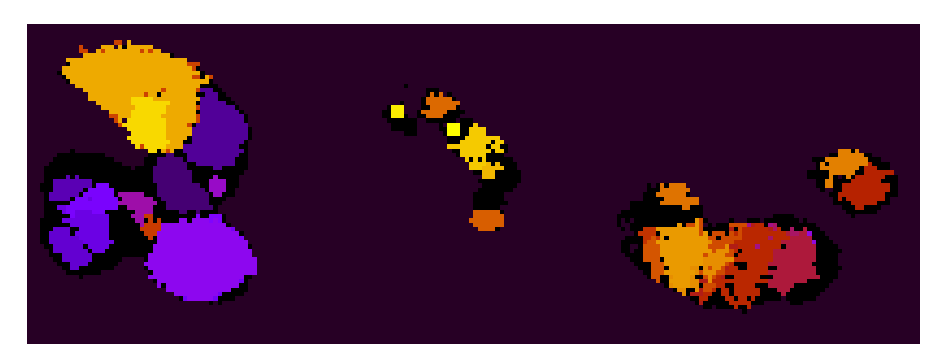

In [69]:
# Show
fig,ax=plt.subplots(figsize=(16,16))
ax.matshow(initial_classification,cmap='gnuplot')
ax.axis('off')
plt.show()

In [70]:
# Parameters
V = 1
thresh = 0.1
alpha = 50
unclassified_cost = 10000
grow_merge_new_ratio = [1,1000,1000]
N_rand_positions = 20

classification = Classification(R_Nx=R_Nx,R_Ny=R_Ny,N=N,
                                V=V,thresh=thresh,alpha=alpha,unclassified_cost=unclassified_cost,
                                grow_merge_new_ratio=grow_merge_new_ratio,
                                N_rand_positions=N_rand_positions,
                                braggpeak_sets_by_scan_position=braggpeak_sets_by_scan_position,
                                #classification=np.where(initial_classification!=-1,initial_classification,0))
                                classification=initial_classification)

/home/ben/Software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide
/home/ben/Software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in greater


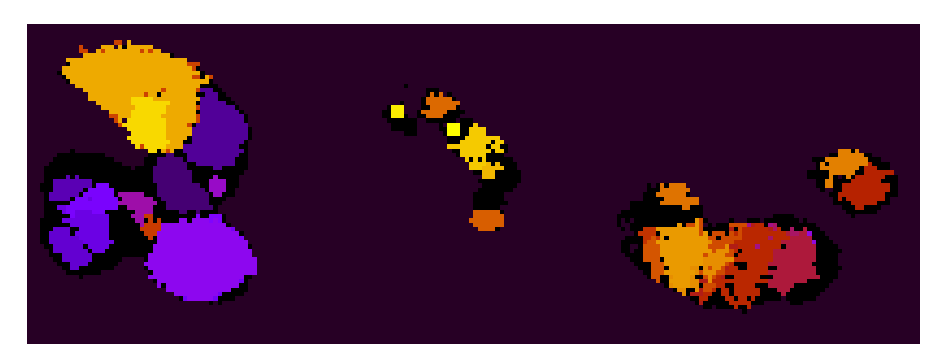

Cost = 11949226.192230877


In [71]:
# Show
fig,ax=plt.subplots(figsize=(16,16))
ax.matshow(classification.classification_current,cmap='gnuplot')
ax.axis('off')
plt.show()

print("Cost = {}".format(classification.get_cost_current()))

In [72]:
for i in range(100):
    classification.get_new_state()

N_classes = 39
63.36448102743101
N_classes = 37
229950
N_classes = 37
34.71122832854047
N_classes = 40
113.09284858594826
N_classes = 38
-22.36972606289008
N_classes = 39
-22.586325544193897
N_classes = 40
153.52508960573482
N_classes = 40
-57.15128205128204
N_classes = 41
-37.53164514393271
N_classes = 42
-26.800359516287244
N_classes = 43
20000
N_classes = 43
-13.125327482123936
N_classes = 44
-12.965710486320859


/home/ben/Software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide
/home/ben/Software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in greater


AttributeError: 'NoneType' object has no attribute 'cost'

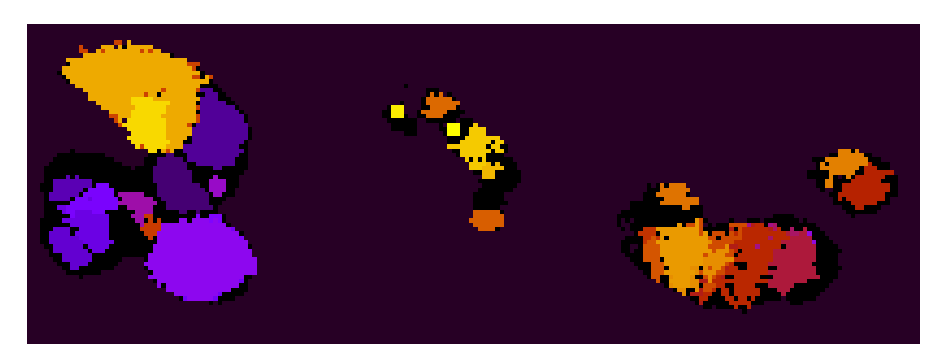

Cost = 11976457.192230877


In [693]:
# Show
fig,ax=plt.subplots(figsize=(16,16))
ax.matshow(classification.classification_current,cmap='gnuplot')
ax.axis('off')
plt.show()

print("Cost = {}".format(classification.get_cost_current()))